In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4639728346491106970,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5730467840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17915750164910816217
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"]

In [3]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/All_cases_100x100_per500_zoom_06222022.hdf5', mode='r')
# h5 = h5py.File('./data/test.hdf5', mode='r')
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)
print(dataset.shape)

[ 0  3  6  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 28 29 30
 31 32 33 34 35 37 38 40 43 44 45 47 49 50 51 52 55 56 58 59 60 61 62 63
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 82 83 84 86 88 90 91]
[ 1  2  4  5  7 14 27 36 39 41 42 46 48 53 54 57 64 65 80 81 85 87 89]
(92, 70, 100, 100, 2)


In [4]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

dataset.shape

(92, 70, 100, 100, 2)

In [5]:
def create_shifted_frames_3to1(data):
    x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
    x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
    x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
    x = np.concatenate((x1,x2,x3), axis=4)
    y = data[:, 4 : data.shape[1], :, :, 0]
    y = np.expand_dims(y,4)
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
x_val, y_val = create_shifted_frames_3to1(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (69, 66, 100, 100, 3), (69, 66, 100, 100, 1)
Validation Dataset Shapes: (23, 66, 100, 100, 3), (23, 66, 100, 100, 1)


Displaying frames for example 19.


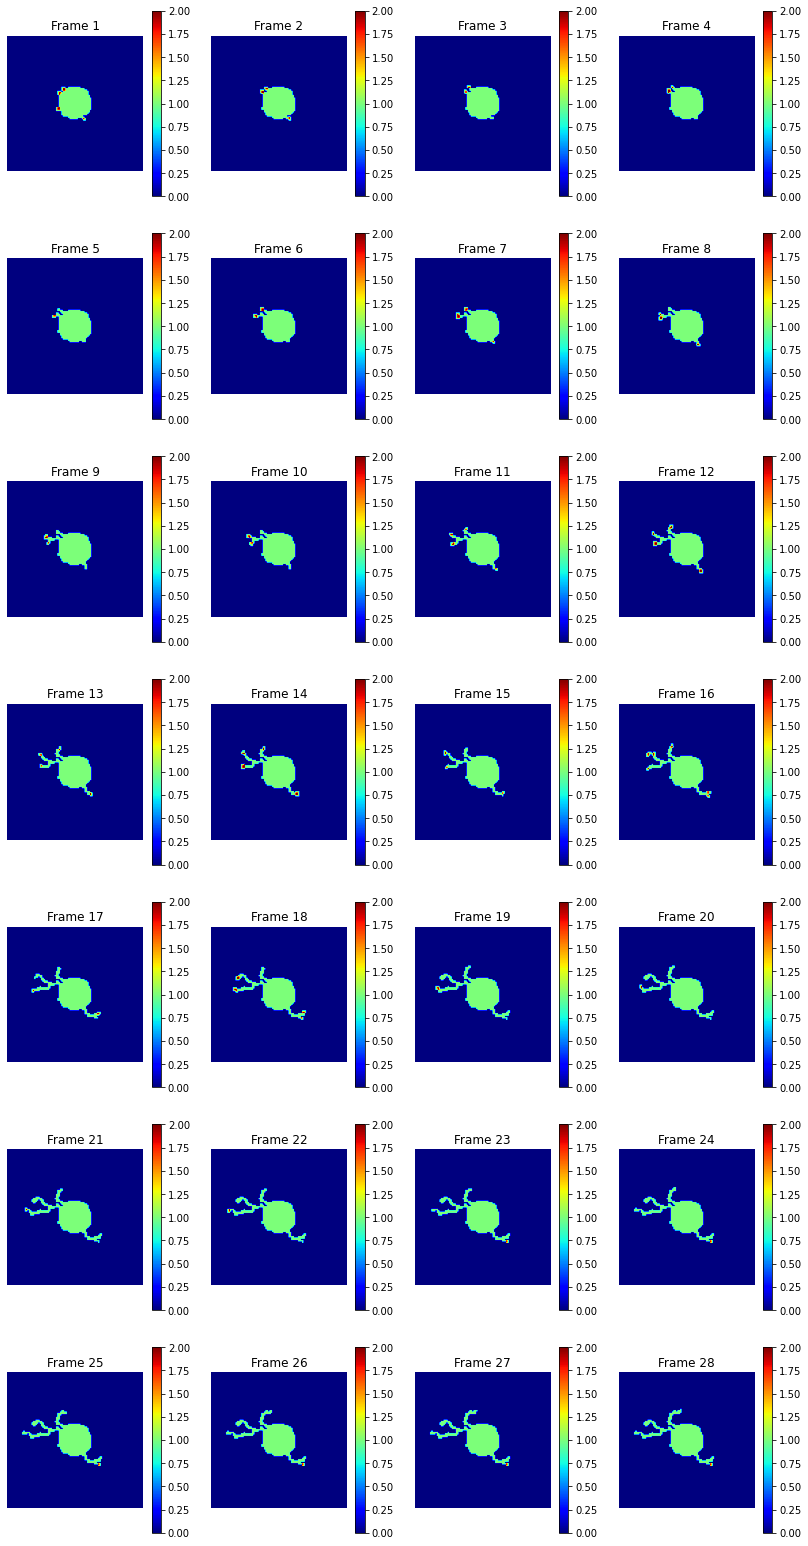

In [6]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

data_choice = np.random.choice(range(len(x_train)), size=1)[0]
fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(x_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

Displaying frames for example 19.


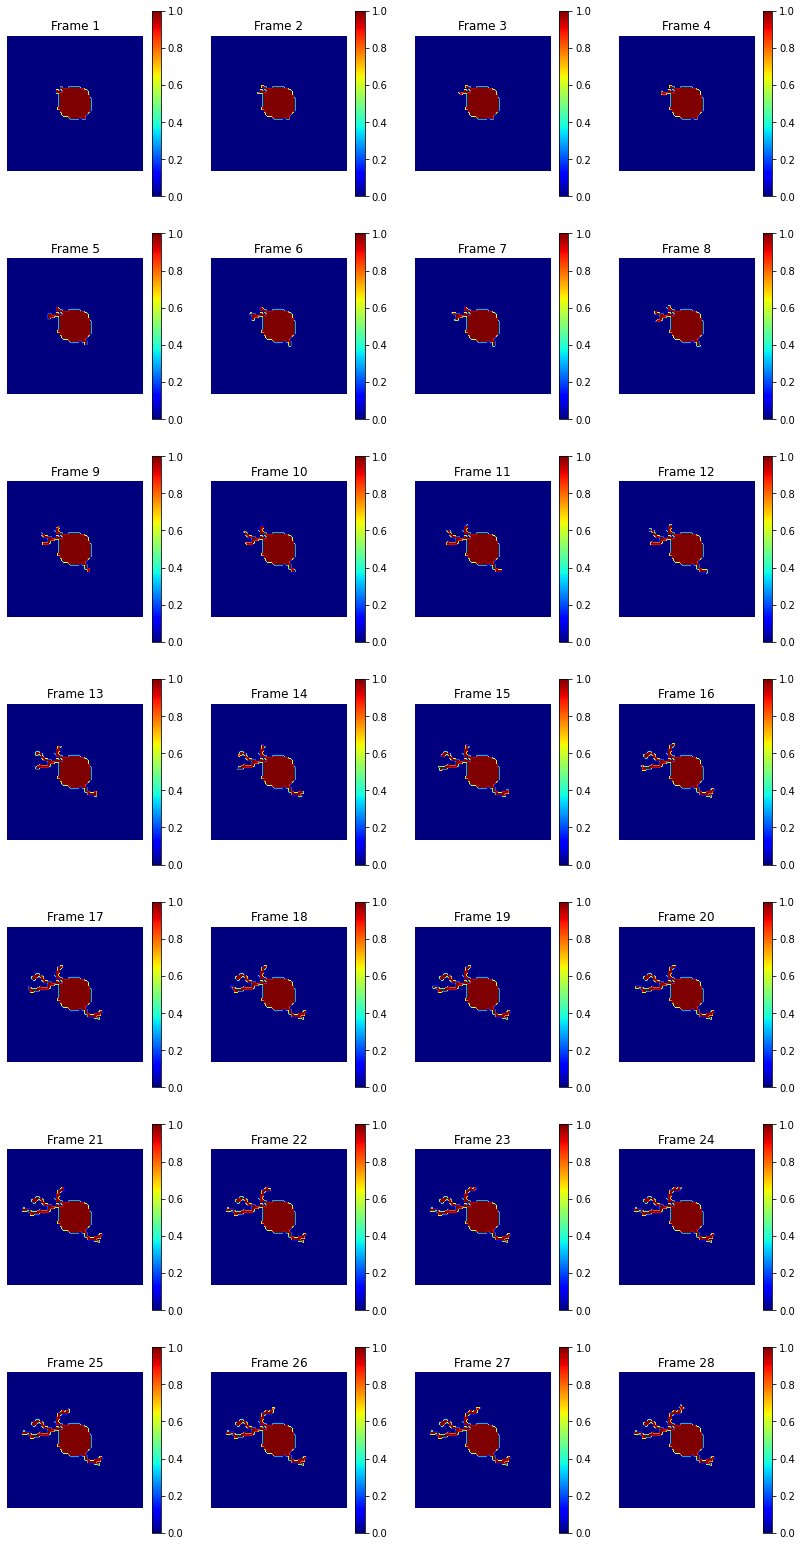

In [7]:
fig, axes = plt.subplots(7, 4, figsize=(14, 28))

fig_ind = 1
for idx, ax in enumerate(axes.flat):
    plt.subplot(7,4,fig_ind)
    fig_ind += 1
    plt.imshow(np.squeeze(y_train[data_choice][idx][:,:,0]),cmap='jet')
    plt.title(f"Frame {idx + 1}")
    plt.axis("off")
    plt.colorbar()
    
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x0 = layers.Dropout(drop_rate)(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x1 = layers.Dropout(drop_rate)(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x3)
x4 = layers.Dropout(drop_rate)(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(x5)
x6 = layers.Dropout(drop_rate)(x6)

In [9]:
# def sum_filter_python(phi):
#     phi = phi.numpy()
#     Nx = phi.shape[0]
#     Ny = phi.shape[1]
#     phi = np.round(phi)

#     phi_sum = np.zeros([Nx,Ny])
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]

#     phi_sum = np.divide(phi,phi_sum)
#     phi_sum[np.isnan(phi_sum)] = 0
#     phi_sum_max = np.amax(np.amax(phi_sum))
#     phi_sum = np.divide(phi_sum,phi_sum_max)

#     phi_sum_temp = phi_sum
#     cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
#     phi_sum[phi_sum<cutoff] = 0
#     phi_sum[phi_sum!=1] = 0  
#     out = tf.Variable(tf.zeros([Nx,Ny],tf.float64))
#     out.assign(phi_sum)
#     return out

# def highlightZone(tip):
#     [Max_y,Max_x] = np.where(tip==1)
#     size_Max = len(Max_x)
#     Nx, Ny = phi_plot.shape
#     tips = np.zeros([Nx,Ny])
#     temp = np.zeros([Nx,Ny])
#     for l in range(0,size_Max):
#         max_x = Max_x[l]
#         max_y = Max_y[l]
#         for i in range(max_y-2,max_y+2):
#             for j in range(max_x-2,max_x+2):
#                     temp[i,j] = 1
#         tips = tips+temp

#     tips[np.abs(tips)>0] = 1
#     return tips

In [10]:
# def sum_filter_python(phi):
#     [Nx,Ny] = tf.shape(phi)
#     phi = tf.math.round(phi)
#     phi_sum = tf.Variable(tf.zeros([Nx,Ny],tf.float32))
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k].assign(tf.math.add(tf.cast(phi[i,k],tf.float32),tf.multiply(tf.cast(phi[i,k]==phi[i-4,j],tf.float32),phi[i-4,j])))

#     return phi_sum

In [11]:
# import scipy.io
# cm = scipy.io.loadmat('cm_20.mat')["cm"][0]
# cm["NuNv"][0] = cm["NuNv"][0].todense()
# cm["N1uNv"][0] = cm["N1uNv"][0].todense()
# cm["NuN1v"][0] = cm["NuN1v"][0].todense()
# cm["N2uNv"][0] = cm["N2uNv"][0].todense()
# cm["NuN2v"][0] = cm["NuN2v"][0].todense()
# cm["N2uN2v"][0] = cm["N2uN2v"][0].todense()

In [12]:
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# drop_rate = 0.1
# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=32,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="sigmoid",
# ))(x0)

In [13]:
# from tensorflow.keras import backend as K

# def PINN_loss_1(cm, inp):
#     def loss(y_true, y_pred):
#         NuNv = cm["NuNv"][0]
#         N1uNv = cm["N1uNv"][0]
#         NuN1v = cm["NuN1v"][0]
#         N2uNv = cm["N2uNv"][0]
#         NuN2v = cm["NuN2v"][0]
#         N2uN2v = cm["N2uN2v"][0]

#         # need to figure the correct dt, and T_pre
#         dt = 1
#         T_pre = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
#         xtheta = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
        
#         phiK = tf.linalg.solve(NuNv,tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
#         # error when calling tf.linalg.solve the second time, suspecting memory related issue
#         phi = tf.linalg.solve(NuNv, tf.cast(K.reshape(inp[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
#         # phi = phiK

#         NNpk = tf.linalg.matmul(NuNv,phiK)
#         NNp = tf.linalg.matmul(NuNv,phi)

#         # Temperature calculation
#         T = (3*tf.linalg.matmul(N2uN2v,T_pre)+4*(NNpk - NNp)/dt + T_pre)*dt

#         # Energy calculation
#         E = 0.2865*tf.math.atan(10*(1-T))

#         # Tubulin

#         # a, aap
#         N1Np = tf.linalg.matmul(N1uNv,phi)
#         NN1p = tf.linalg.matmul(NuN1v,phi)
#         atheta = tf.math.atan2(NN1p,N1Np)
#         epsilon = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-xtheta)))
#         epsilon_deriv = -0.04*(6*0.1*tf.math.sin(6*(atheta-xtheta)))
#         aap = tf.math.multiply(epsilon,epsilon_deriv)

#         # phi
#         # (phiK-phi)/dt = 60*()
#         residual = tf.math.add(tf.math.add(E,T),epsilon_deriv)

#         print(phiK.shape)
#         print(phiK.dtype)        
        
#         inn = tf.keras.backend.cast(inp[0,0,:,:,0],dtype='float64')
#         print(inn.shape)
#         print(inn.dtype)
#         residual = inn

#         return residual
#     return loss

In [26]:
from tensorflow.keras import backend as K

def get_deriv(input):
    # N1N_pK, NN1_pK = tf.image.image_gradients(NN_pK)
    # N2N_pK, _ = tf.image.image_gradients(N1N_pK)
    # _, N2N_pK = tf.image.image_gradients(NN1_pK)
    # LAP_pK = tf.math.add(N2N_pK,N2N_pK)

    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

def PINN_loss():
    def loss(y_true, y_pred):
        print( tf.math.reduce_mean(y_pred))
        # need to figure the correct dt, and T_pre
        dt = 0.01*1000
        # variables should be from inp
        tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        theta = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        # N1N_pK, NN1_pK, N2N_pK, N2N_pK, LAP_pK = get_deriv(NN_pK)
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_pre)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_pre)

        # Temperature calculation
        tempr = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_pre

        # Tubulin Equation
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_pre) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_pre) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_pre)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_K = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_pre

        # Energy calculation
        E = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_K-0.1,1-tempr))

        # phase field equation residual
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + E + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt
        
        residual = tf.math.reduce_mean(phi_residual)
        return residual
    return loss

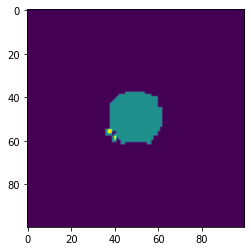

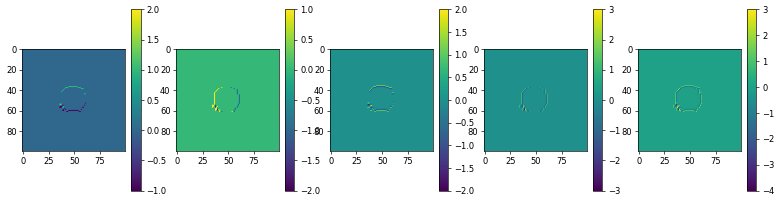

In [27]:
import scipy.io
inn = scipy.io.loadmat('phi_plot.mat')['phi_plot']
inn = x_train[0,0,:,:,0]
plt.imshow(inn)
inn = tf.expand_dims(tf.expand_dims(inn, axis=0), axis=3)
N1Np, NN1p = tf.image.image_gradients(inn)
N2Np, _ = tf.image.image_gradients(N1Np)
_, NN2p = tf.image.image_gradients(NN1p)
lap = tf.math.add(N2Np,NN2p)
plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,5,1)
plt.imshow(N1Np[0,:,:,0])
plt.colorbar()
plt.subplot(1,5,2)
plt.imshow(NN1p[0,:,:,0])
plt.colorbar()
plt.subplot(1,5,3)
plt.imshow(N2Np[0,:,:,0])
plt.colorbar()
plt.subplot(1,5,4)
plt.imshow(NN2p[0,:,:,0])
plt.colorbar()
plt.subplot(1,5,5)
plt.imshow(lap[0,:,:,0])
plt.colorbar()


In [28]:
# need to figure the correct dt, and T_pre
dt = 1
# variables should be from inp
tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(inn[0,:,:,0],axis=0),axis=3), dtype=tf.float64)
theta = tf.cast(tf.expand_dims(tf.expand_dims(inn[0,:,:,0],axis=0),axis=3), dtype=tf.float64)
NN_p = tf.cast(tf.expand_dims(tf.expand_dims(inn[0,:,:,0],axis=0),axis=3), dtype=tf.float64)
tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(inn[0,:,:,0],axis=0),axis=3), dtype=tf.float64)

NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(inn[0,:,:,0],axis=0),axis=3), dtype=tf.float64)

# N1N_pK, NN1_pK, N2N_pK, N2N_pK, LAP_pK = get_deriv(NN_pK)
N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
_, _, _, _, LAP_tp = get_deriv(tempr_pre)
N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_pre)

# Temperature calculation
tempr = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_pre

# Tubulin Equation
diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_pre) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_pre) + tf.math.multiply(NN_p,NN1_tb))
beta_tb = 0.001*tf.math.multiply(NN_p,tub_pre)
# problem with src_tb
src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
tub_K = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_pre

# Energy calculation
E = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_K-0.1,1-tempr))

# phase field equation residual
atheta = tf.math.atan2(NN1_p,N1N_p)
a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
aap = tf.math.multiply(a,ap)
a2 = tf.math.square(a)
a2Lap = tf.math.multiply(a2,LAP_p)
N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
_, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + E + 6*0.007*mag_theta)
phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

print(tf.math.reduce_mean(tf.square(tf.math.subtract(inn[0,:,:,0], phi_residual[0,:,:,0]))))

tf.Tensor(0.05941438246466735, shape=(), dtype=float64)


In [29]:
model = keras.models.Model(inp, x1)
model.compile(
    # loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-10))
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 100, 100, 3 0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 48, 48, 64)  4864      
_________________________________________________________________
dropout (Dropout)            (None, None, 48, 48, 64)  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 22, 22, 128) 204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 22, 22, 128) 0         
Total params: 209,792
Trainable params: 209,792
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [31]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 1
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[saver,early_stopping, reduce_lr],
            callbacks=[early_stopping, reduce_lr],
        )
        model.run_eagerly = True

    # model.save('./saved_model/model_conv_lstm_test') 

Epoch 1/1000
Tensor("loss/Mean:0", shape=(), dtype=float32)
Tensor("loss/Mean:0", shape=(), dtype=float32)
69/69 [==============================] - 8s 31ms/step - loss: -7.3670e-05 - val_loss: 0.0000e+00
Epoch 2/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/1000
69/69 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000
33/69 [=============>................] - ETA: 0s - loss: 0.0000e+00

KeyboardInterrupt: 

In [21]:
# def create_shifted_frames_3to1(data):
#     x1 = np.expand_dims(data[:, 1 : data.shape[1] - 3, :, :, 0]+data[:, 1 : data.shape[1] - 3, :, :, 1],4)
#     x2 = np.expand_dims(data[:, 2 : data.shape[1] - 2, :, :, 0]+data[:, 2 : data.shape[1] - 2, :, :, 1],4)
#     x3 = np.expand_dims(data[:, 3 : data.shape[1] - 1, :, :, 0]+data[:, 3 : data.shape[1] - 1, :, :, 1],4)
#     x = np.concatenate((x1,x2,x3), axis=4)
#     y = data[:, 4 : data.shape[1], :, :, 0]
#     y = np.expand_dims(y,4)
#     tips = data[:, 4 : data.shape[1], :, :, 1]
#     tips = np.expand_dims(tips,4)
#     return x,y,tips

# x_val, y_val, tips_val = create_shifted_frames_3to1(val_dataset)

In [ ]:
def push(input, cutoff):
    max_input = np.amax(input)
    input[input>cutoff*max_input] = 1
    input[input<=cutoff*max_input] = 0
    return input

In [139]:
rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

new_prediction = model.predict(x_in,verbose="0")
print(new_prediction).shape

plt.figure(figsize=(16, 4), dpi=60)
plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
plt.colorbar()

[[[[[nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]]

   [[nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]]

   [[nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]]

   [[nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]]

   [[nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
    [nan]
  

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
model = keras.models.load_model('./saved_model/model_conv_lstm', compile=False)
model.compile(loss=mreloss)

rand_case = np.random.randint((len(val_dataset)))

example_x = x_val[rand_case,...]
example_y = y_val[rand_case,...]
example_tips = tips_val[rand_case,...]

plt.figure(figsize=(16, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,2)
plt.imshow(example_x[0,:,:,1], cmap='jet')
plt.title('Ground truth at frame 0')

plt.subplot(1,3,3)
plt.imshow(example_x[0,:,:,2], cmap='jet')
plt.title('Ground truth at frame 0')
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(example_x.shape[0]-3):
    # model = keras.models.load_model('./saved_model/model_conv_lstm')
    new_prediction = model.predict(x_in,verbose="0")
    # keras.backend.clear_session()
    temp = np.zeros([1,1,100,100,3])

    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
    # model = keras.models.load_model('./saved_model/model_tipsCNN_predBased_mre', compile=False)
    # model.compile(loss=mreloss)
    # tips = push(model.predict(np.expand_dims(np.expand_dims(new_prediction[0,0,:,:,0],axis=0),axis=3),verbose="0"),0.5)
    # keras.backend.clear_session()
    # tips = np.round(example_tips[i,:,:,0])

    temp[0,0,:,:,0] = x_in[0,0,:,:,1]
    temp[0,0,:,:,1] = x_in[0,0,:,:,2]
    # temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips[0,:,:,0]
    temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips
    x_in = temp

    mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    plt.subplot(1,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[i,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    plt.xlabel('Mean relative error: %f'%mre)

    plt.show()

# eng.quit()


In [ ]:
import matlab.engine
from tqdm import tqdm
eng = matlab.engine.start_matlab()

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in, verbose="0")
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        tips = np.round(example_tips[i,:,:,0])
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
eng.quit()
